<a href="https://colab.research.google.com/github/khalidakhaldi/Disaster_Tweet_Classification/blob/master/Tweet_mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets

## Challenge: Disaster Tweet Classification

In this competition, the challenge is to build a machine learning model that can accurately predict whether a Tweet is about a real disaster or not.

## Dataset Description

**File Descriptions:**



*   train.csv: Contains the training data
*   test.csv: Contains the test data

*   sample_submission.csv: A sample file showing the correct submission format

**Column Descriptions:**


*   id: Unique identifier for each tweet

*   text: The text of the tweet
*   location: The location the tweet was sent from

*  target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

The dataset of 10,000 Tweets  have been manually classified.









In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 18 01:57:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0              27W /  70W |   8309MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Unzip and load the dataset onto your current directory

import zipfile

zip = zipfile.ZipFile('/content/drive/MyDrive/Tweet_Analysis/nlp-getting-started.zip')

zip.extractall("/content/drive/MyDrive/Tweet_Analysis/")

In [ ]:
!pip install tf-keras==2.15.0

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

In [1]:
#!pip uninstall tensorflow

In [ ]:
!pip install tensorflow==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00


In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

Let's begin by setting up our environment and importing the necessary libraries.

In [ ]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
from ktrain import text
from ktrain.text import texts_from_df
import time
import pandas as pd
from keras.preprocessing.text import Tokenizer
import pickle
import json
import glob
import json
import numpy as np

2.15.0


## Load the Disaster Tweets

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Tweet_Analysis/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Tweet_Analysis/test.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
df_test.shape

(3263, 4)

In [ ]:
# Count occurrences of 1 and 0 in the target column
target_counts = df_train['target'].value_counts()

# Display the counts
print(target_counts)

target
0    4342
1    3271
Name: count, dtype: int64


The dataset contains more non-disaster tweets than disaster tweets. The distribution is fairly balanced but slightly skewed towards non-disaster tweets.

In [ ]:
# Update target values directly
df_train.loc[df_train['target'] == 1, 'target'] = 'DISASTER'
df_train.loc[df_train['target'] == 0, 'target'] = 'NOT DISASTER'

# Display the updated DataFrame
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,DISASTER
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,DISASTER
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,DISASTER
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",DISASTER
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,DISASTER


In [ ]:
# Count occurrences of 1 and 0 in the target column
target_counts = df_train['target'].value_counts()

# Display the counts
print(target_counts)

target
NOT DISASTER    4342
DISASTER        3271
Name: count, dtype: int64


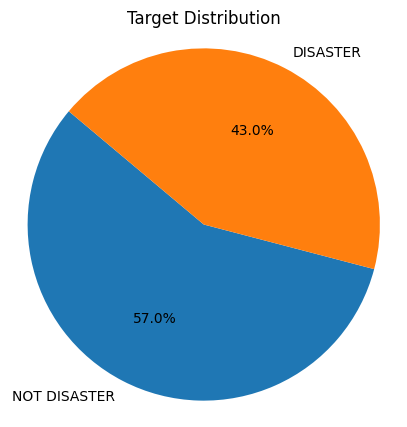

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Count occurrences of 'DISASTER' and 'NOT DISASTER' in the target column
target_counts = df_train['target'].value_counts()

# Plot a pie chart
plt.figure(figsize=(5, 5))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Target Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**Next, we prepare the data for the BERT model, setting a maximum token length and splitting the data into training and validation sets.**

In [ ]:
target_names = ['NOT DISASTER','DISASTER']

In [ ]:
#tf.keras.backend.clear_session()
t = text.Transformer('distilbert-base-uncased', maxlen=512, class_names=target_names)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train, val, preprocess = texts_from_df(df_train, 'text', label_columns=['target'], val_df=None, max_features=20000, maxlen=512, val_pct=0.1, ngram_range=1, preprocess_mode='distilbert', verbose=1)

['DISASTER', 'NOT DISASTER']
      DISASTER  NOT DISASTER
481        0.0           1.0
422        0.0           1.0
5808       1.0           0.0
382        1.0           0.0
2758       1.0           0.0
['DISASTER', 'NOT DISASTER']
      DISASTER  NOT DISASTER
5562       1.0           0.0
2179       1.0           0.0
5841       0.0           1.0
957        0.0           1.0
2088       0.0           1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 15
	95percentile : 24
	99percentile : 27


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 15
	95percentile : 24
	99percentile : 28


In [ ]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

In [ ]:
learner.lr_find(max_epochs=16)

simulating training for different learning rates... this may take a few moments...
Epoch 1/16
428/428 [==============================] - 414s 858ms/step - loss: 0.6834 - accuracy: 0.5869
Epoch 2/16
428/428 [==============================] - 369s 864ms/step - loss: 0.6359 - accuracy: 0.6985
Epoch 3/16
428/428 [==============================] - 368s 861ms/step - loss: 0.4589 - accuracy: 0.8105
Epoch 4/16
428/428 [==============================] - 368s 859ms/step - loss: 0.3803 - accuracy: 0.8462
Epoch 5/16
428/428 [==============================] - 368s 859ms/step - loss: 0.3442 - accuracy: 0.8610
Epoch 6/16
428/428 [==============================] - 367s 858ms/step - loss: 0.3275 - accuracy: 0.8742
Epoch 7/16
428/428 [==============================] - 367s 858ms/step - loss: 0.3815 - accuracy: 0.8373
Epoch 8/16
428/428 [==============================] - 366s 855ms/step - loss: 0.6282 - accuracy: 0.6383
Epoch 9/16
428/428 [==============================] - 366s 855ms/step - loss: 0.6876 

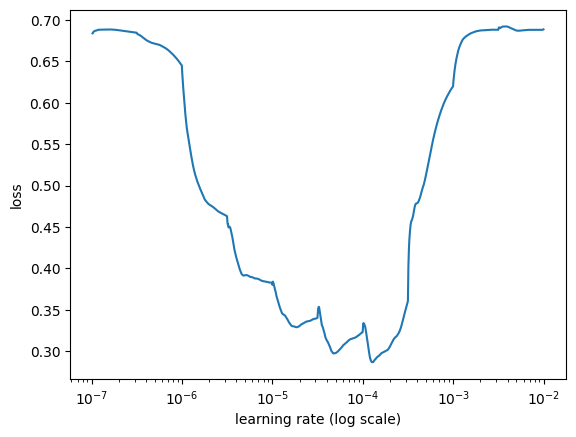

In [ ]:
learner.lr_plot()

**We will now train the model using the autofit method, which includes early stopping to prevent overfitting.**

In [ ]:
history=learner.autofit(10**(-4),checkpoint_folder='checkpoint',epochs=12, early_stopping=True)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/12
429/429 [==============================] - 380s 882ms/step - loss: 0.4502 - accuracy: 0.8149 - val_loss: 0.4871 - val_accuracy: 0.7913
Epoch 2/12
429/429 [==============================] - 371s 864ms/step - loss: 0.3898 - accuracy: 0.8386 - val_loss: 0.4431 - val_accuracy: 0.8097
Epoch 3/12
429/429 [==============================] - 371s 865ms/step - loss: 0.3163 - accuracy: 0.8807 - val_loss: 0.4787 - val_accuracy: 0.8058
Epoch 3: early stopping
Weights from best epoch have been loaded into model.


**After training, we evaluate the model's performance on the validation set.**

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [ ]:
validation = learner.validate(val_data=val, print_report=True)

24/24 [==============================] - 9s 91ms/step
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       308
           1       0.82      0.87      0.84       454

    accuracy                           0.81       762
   macro avg       0.81      0.80      0.80       762
weighted avg       0.81      0.81      0.81       762



##  submission

In [ ]:
# Convert the DataFrame to a list of texts or inputs
test_texts = df_test['text'].tolist()

In [ ]:
# Get predictions
predictions = predictor.predict(test_texts)  # or predictor.predict_proba(test_texts) for probabilities

# If you want to add the predictions back to the DataFrame
df_test['target'] = predictions

In [ ]:
df_test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,DISASTER
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",DISASTER
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",DISASTER
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,DISASTER
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,DISASTER


In [ ]:
# Map target labels to numerical values
df_test['target'] = df_test['target'].map({'DISASTER': 1, 'NOT DISASTER': 0})
sample_submission = pd.read_csv("/content/drive/MyDrive/Tweet_Analysis/sample_submission.csv")
sample_submission["target"]  = df_test["target"]
sample_submission.to_csv("/content/drive/MyDrive/Tweet_Analysis/submission.csv", index=False)

In [ ]:
# Count occurrences of 1 and 0 in the target column
target_counts = df_test['target'].value_counts()

# Display the counts
print(target_counts)

target
NOT DISASTER    2009
DISASTER        1254
Name: count, dtype: int64


In [ ]:
df_test['target'] = df_test['target'].map({'DISASTER': 1, 'NOT DISASTER': 0})
# Map target labels to numerical values


In [ ]:
# Map target labels to numerical values
df_test['target'] = df_test['target'].map({'DISASTER': 1, 'NOT DISASTER': 0})

In [ ]:
# Count occurrences of 1 and 0 in the target column
target_counts = df_test['target'].value_counts()

# Display the counts
print(target_counts)

target
0    2009
1    1254
Name: count, dtype: int64


In [ ]:
df_test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [ ]:
sample_submission = pd.read_csv("/content/drive/MyDrive/Tweet_Analysis/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
sample_submission["target"]  = df_test["target"]

In [ ]:
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
sample_submission.to_csv("/content/drive/MyDrive/Tweet_Analysis/submission.csv", index=False)

# Summary

The model performs well with an overall accuracy of 81%. It is better at identifying disaster tweets (class 1) than non-disaster tweets (class 0), as indicated by higher recall and F1-score for class 1. The precision, recall, and F1-score are reasonably balanced, indicating a reliable model.